In [97]:
import pandas as pd 

In [98]:
df = pd.read_excel('../data/processed/DOE_Stage_2.xlsx')

In [99]:
df.head()

,Month,Time Event Began,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected
0,January,2002-01-29 16:00:00,2002-01-29 19:30:00,Metropolitan Kansas City Area,SPP,Unkown,Severe Weather - Winter/Snow/Ice,600.0,270000.0
1,January,2002-01-30 06:00:00,2002-01-30 12:00:00,Oklahoma,SPP,Unknown,Severe Weather - Winter/Snow/Ice,500.0,1881134.0
2,January,2002-01-30 16:00:00,2002-01-30 21:00:00,Missouri,SPP,Unknown,Severe Weather - Winter/Snow/Ice,210.0,95000.0
3,February,2002-02-27 10:48:00,2002-02-27 11:35:00,California,WECC,Unknown,Unkown/Unspecified,300.0,255000.0
4,March,2002-03-09 00:00:00,2002-03-09 12:00:00,Lower Peninsula of Michigan,RFC,Unknown,Severe Weather - Unspecified/Other,190.0,190000.0


In [100]:
col = df.columns.tolist()
df = df.rename(str.lower, axis='columns')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3892 entries, 0 to 3891
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   month                         3892 non-null   object        
 1   time event began              3892 non-null   datetime64[ns]
 2   time of restoration           3892 non-null   datetime64[ns]
 3   area affected                 3892 non-null   object        
 4   nerc region                   3892 non-null   object        
 5   alert criteria                3892 non-null   object        
 6   event type                    3892 non-null   object        
 7   demand loss (mw)              2441 non-null   float64       
 8   number of customers affected  3157 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 273.8+ KB


In [102]:
df['demand loss (mw)'] = pd.to_numeric(df['demand loss (mw)'], errors='coerce')
df['number of customers affected'] = pd.to_numeric(df['number of customers affected'], errors='coerce')

In [103]:
# fillna for "demand loss" based on Event type and NERC Region averages.
df['demand loss (mw)'] = df.groupby(['event type','nerc region'])['demand loss (mw)'].transform(lambda x: x.fillna(x.mean()))
df['demand loss (mw)'] = df.groupby(['event type'])['demand loss (mw)'].transform(lambda x: x.fillna(x.mean()))

df['demand loss (mw)'] = df['demand loss (mw)'].round(2)

In [104]:
# fillna for "number of customers affected" based on Event type and NERC Region averages.
df['number of customers affected'] = df.groupby(['event type','nerc region'])['number of customers affected'].transform(lambda x: x.fillna(x.mean()))
df['number of customers affected'] = df.groupby(['event type'])['number of customers affected'].transform(lambda x: x.fillna(x.mean()))


df['number of customers affected'] = df['number of customers affected'].round(0).astype('Int64')

In [105]:
# fill in remaing missing values with event type grouping
df['demand loss (mw)'] = df.groupby(['event type','nerc region'])['demand loss (mw)'].transform(lambda x: x.fillna(x.mean()))

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3892 entries, 0 to 3891
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   month                         3892 non-null   object        
 1   time event began              3892 non-null   datetime64[ns]
 2   time of restoration           3892 non-null   datetime64[ns]
 3   area affected                 3892 non-null   object        
 4   nerc region                   3892 non-null   object        
 5   alert criteria                3892 non-null   object        
 6   event type                    3892 non-null   object        
 7   demand loss (mw)              3892 non-null   float64       
 8   number of customers affected  3892 non-null   Int64         
dtypes: Int64(1), datetime64[ns](2), float64(1), object(5)
memory usage: 277.6+ KB


In [107]:
# Calculate the duration column
df['duration'] = df['time of restoration'] - df['time event began']

# Filter rows with negative duration
negative_duration_df = df[df['duration'] < pd.Timedelta(0)]

# Display the DataFrame with negative duration
print(negative_duration_df.count())

month                           763
time event began                763
time of restoration             763
area affected                   763
nerc region                     763
alert criteria                  763
event type                      763
demand loss (mw)                763
number of customers affected    763
duration                        763
dtype: int64


```
# Calculate the duration column
df['duration'] = df['time of restoration'] - df['time event began']

# Filter rows with negative duration
negative_duration_df = df[df['duration'] < pd.Timedelta(0)]

# Display the DataFrame with negative duration
print(negative_duration_df.count())
```
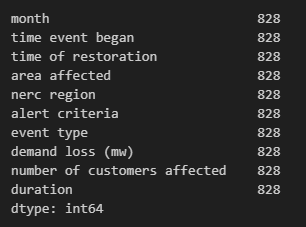

In [108]:
# Create a mask for rows where the date difference is negative and 'time of restoration' starts with 00: and has minutes
mask = (df['time of restoration'].dt.strftime('%H:%M') == '00:') & (df['time of restoration'].dt.minute > 0) & (df['time of restoration'] < df['time event began'])

# Add a day to 'time of restoration' for rows where the mask is True
df.loc[mask, 'time of restoration'] += pd.DateOffset(days=1)


In [109]:
negative_diff_mask = df['time of restoration'] < df['time event began']

# Swap dates for rows with negative date difference
df.loc[negative_diff_mask, ['time event began', 'time of restoration']] = df.loc[negative_diff_mask, ['time of restoration', 'time event began']].values

df.head()

,month,time event began,time of restoration,area affected,nerc region,alert criteria,event type,demand loss (mw),number of customers affected,duration
0,January,2002-01-29 16:00:00,2002-01-29 19:30:00,Metropolitan Kansas City Area,SPP,Unkown,Severe Weather - Winter/Snow/Ice,600.0,270000,0 days 03:30:00
1,January,2002-01-30 06:00:00,2002-01-30 12:00:00,Oklahoma,SPP,Unknown,Severe Weather - Winter/Snow/Ice,500.0,1881134,0 days 06:00:00
2,January,2002-01-30 16:00:00,2002-01-30 21:00:00,Missouri,SPP,Unknown,Severe Weather - Winter/Snow/Ice,210.0,95000,0 days 05:00:00
3,February,2002-02-27 10:48:00,2002-02-27 11:35:00,California,WECC,Unknown,Unkown/Unspecified,300.0,255000,0 days 00:47:00
4,March,2002-03-09 00:00:00,2002-03-09 12:00:00,Lower Peninsula of Michigan,RFC,Unknown,Severe Weather - Unspecified/Other,190.0,190000,0 days 12:00:00


In [110]:
# Calculate the duration column
df['duration'] = df['time of restoration'] - df['time event began']

# Filter rows with negative duration
negative_duration_df = df[df['duration'] < pd.Timedelta(0)]

# Display the DataFrame with negative duration
print(negative_duration_df.count())

month                           0
time event began                0
time of restoration             0
area affected                   0
nerc region                     0
alert criteria                  0
event type                      0
demand loss (mw)                0
number of customers affected    0
duration                        0
dtype: int64


In [122]:
# Find duplicate dates
duplicate_dates = df[df.duplicated('time event began', keep=False)]['time event began']

print(duplicate_dates.count())

208


In [123]:
df2 = df.copy()
df2 = df2.rename(str.upper, axis='columns')

df2.to_excel('../data/processed/DOE_Stage_3.xlsx', index=False)

In [111]:
df3 = df.copy()
df3 = df3.rename(str.upper, axis='columns')

df2.to_excel('../data/processed/DOE_final.xlsx', index=False)

In [121]:
# Find duplicate dates
duplicate_dates = df[df.duplicated('time event began', keep=False)]['time event began']

print(duplicate_dates.count())

208


In [117]:
df.head(100)

,month,time event began,time of restoration,area affected,nerc region,alert criteria,event type,demand loss (mw),number of customers affected,duration
0,January,2002-01-29 16:00:00,2002-01-29 19:30:00,Metropolitan Kansas City Area,SPP,Unkown,Severe Weather - Winter/Snow/Ice,600.0,270000,0 days 03:30:00
1,January,2002-01-30 06:00:00,2002-01-30 12:00:00,Oklahoma,SPP,Unknown,Severe Weather - Winter/Snow/Ice,500.0,1881134,0 days 06:00:00
2,January,2002-01-30 16:00:00,2002-01-30 21:00:00,Missouri,SPP,Unknown,Severe Weather - Winter/Snow/Ice,210.0,95000,0 days 05:00:00
3,February,2002-02-27 10:48:00,2002-02-27 11:35:00,California,WECC,Unknown,Unkown/Unspecified,300.0,255000,0 days 00:47:00
4,March,2002-03-09 00:00:00,2002-03-09 12:00:00,Lower Peninsula of Michigan,RFC,Unknown,Severe Weather - Unspecified/Other,190.0,190000,0 days 12:00:00
...,...,...,...,...,...,...,...,...,...,...
95,June,2004-06-02 02:35:00,2004-06-02 18:00:00,"Tulsa, Oklahoma",SPP,Unknown,Severe Weather - Lightning/Thunderstorm/Hail,280.0,56874,0 days 15:25:00
96,June,2004-06-12 17:37:00,2004-06-12 17:41:00,"Lincoln, Nebraska",MRO,Unknown,Natural Disasters - Earthquake/Hurricane/Torna...,428.0,120212,0 days 00:04:00
97,June,2004-06-14 07:41:00,2004-06-14 14:39:00,"Phoenix, Arizona",WECC,Unknown,Equipment Failure,200.0,30000,0 days 06:58:00
98,June,2004-06-23 17:35:00,2004-06-23 19:10:00,Southern Idaho,WECC,Unknown,Unkown/Unspecified,157.0,35000,0 days 01:35:00


In [119]:
df3 = df.copy()
df3 = df2.rename(str.upper, axis='columns')

df3.to_excel('../data/processed/DOE_full.xlsx', index=False)